# Exploratory Topic Models on Area Descriptions

We run exploratory topic models on area descriptions. Why? Because we can!

In [1]:
import lucem_illud
import gensim
import pandas as pd
import regex as re

from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import nltk.downloader
from nltk.corpus import wordnet
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt

nltk.downloader.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wimer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Our data is really limited, so we combine three text data sources associated with each HOLC neighborhood:

1. The posted description (`ad_data.description`)

2. Additional miscellaneous data (`data.data`)

3. Additional notes (`data.note`)

We argue that the corpera of interest is really just words associated with the HOLC neighborhood and descriptions given of the neighborhoods, making this an appropriate sample of text. Additionally, we combine these variables on the following rules:

1. `data.data` and `data.note` are filtered to only include entries with at least five words -- _not numbers_. This filtering is done to heuristically identify sentences.



In [2]:
ad_data = pd.read_json('../data/shapes/ad_data.json')

ad_data.shape

(7930, 155)

In [3]:
ad_data.head(5)

,area_id,label,city_id,city,state,form_id,grade,name_of_city,security_grade,area_number,...,new_construction_how_selling,overhang_holc,overhang_institutions,sales_holc,sales_institutions,mortagage_funds,tax_rate_193X,tax_rate_dollars,location,date
0,3948,A1,11,Mobile,AL,19370601,A,"Mobile, Alabama",Best,"A-1, 2, 3, 4, 5, 6.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3929,A2,11,Mobile,AL,19370601,A,"Mobile, Alabama",Best,"A-1, 2, 3, 4, 5, 6.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3926,A3,11,Mobile,AL,19370601,A,"Mobile, Alabama",Best,"A-1, 2, 3, 4, 5, 6.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7175,A4,11,Mobile,AL,19370601,A,"Mobile, Alabama",Best,"A-1, 2, 3, 4, 5, 6.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3938,A5,11,Mobile,AL,19370601,A,"Mobile, Alabama",Best,"A-1, 2, 3, 4, 5, 6.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ad_data.columns.tolist()

['area_id',
 'label',
 'city_id',
 'city',
 'state',
 'form_id',
 'grade',
 'name_of_city',
 'security_grade',
 'area_number',
 'description_of_terrain',
 'favorable_influences',
 'detrimental_influences',
 'occupation_or_type',
 'estimated_annual_family_income',
 'foreign_born_nationality',
 'foreign_born_percent',
 'negro_yes_or_no',
 'negro_percent',
 'infiltration_of',
 'relief_families',
 'population_increasing',
 'population_decreasing',
 'buildings_type',
 'construction',
 'average_age',
 'repair',
 'price_range_dollars_1929',
 'price_predominating_1929',
 'rent_range_dollars_1929',
 'rent_predominating_1929',
 'middle_year',
 'price_range_dollars_middle_year',
 'price_predominating_dollars_middle_year',
 'price_range_percent_middle_year',
 'rent_range_middle_year',
 'rent_predominating_middle_year',
 'rent_range_percent_middle_year',
 'last_year',
 'price_range_dollars_last_year',
 'price_predominating_dollars_last_year',
 'price_range_percent_last_year',
 'rent_range_last_year

In [5]:
ad_data.selected_fields[::1000].tolist()

['These 6 areas contain about 35 houses, practically all of which are of modern construction. Level to elevated. Principal subdivisions known as Woodlawn (A-1), Beverly Hills (A-3), Du Broca Tract (A-4 ,5) and Roberts-Hunter Tract (A-6). Proximity to $1,000,000 public high school; good transportation facilities, practically all streets paved, presence of neighborhood business center. All utilities in. None Executives, business and professional men. Practically none None None',
 'An area very difficult to grade. It would be “A” were it not for the age of its large two-story houses, occupied by the leading most affluent families. On the north side of Frederick covering many acres, is the Wyatt estate, one of the largest and best in western Missouri. Across the street is a new $35,000 house. The area is beautifully situated on Noyes Boulevard and Frederick Avenue. This was St. Joseph’s swank district, 20 years ago. Real estate men do not remember a sale in this area in the last 8 years. T

### todo: preprocess so you don't have overly common or overly rare words.

In [6]:
tm_data = ad_data.copy()[['area_id', 'selected_fields', 'grade']]

tm_data['tokenized_text'] = tm_data['selected_fields'].apply(
    lambda x: lucem_illud.word_tokenize(x)
)

tm_data['normalized_tokens'] = tm_data['tokenized_text'].apply(
    lambda x: lucem_illud.normalizeTokens(x)
)

tm_data.head()

C:\Users\wimer\AppData\Roaming\Python\Python311\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,area_id,selected_fields,grade,tokenized_text,normalized_tokens
0,3948,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."
1,3929,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."
2,3926,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."
3,7175,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."
4,3938,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."


In [7]:
# TODO: Apply topic model on each type of grade--

def find_common_words(df, column='normalized_tokens', nwords=20):
    full_text = ""
    for _, row in df.iterrows():
        full_text = full_text + " " + ' '.join(row[column])

    allWords = nltk.tokenize.word_tokenize(full_text)
    allWordDist = nltk.FreqDist(w.lower() for w in allWords)
    
    mostCommon= allWordDist.most_common(nwords)
    
    return mostCommon, allWordDist

def get_wordnet_pos(treebank_tag):
    '''
    pos_tag uses the treebank tag system, but we need things in the wordnet
    system. This function handles the conversion
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    
    return ''

def drop_bad(token_lst, add_stop_words=[], vocab_lst = set()):
    '''
    Exclude one letter tokens, all numerics.
    '''
    rv = []

    pos_lst = pos_tag(token_lst)
    pos_lst = [(token, get_wordnet_pos(pos)) for (token, pos) in pos_lst
               if get_wordnet_pos(pos)]

    lemmatizer = WordNetLemmatizer()
    for token, pos in pos_lst:

        if not pos:
            continue
        
        if len(token) <= 2:
            continue

        if re.search(r"[0-9]+", token):
            continue

        if token in add_stop_words:
            continue
        
        if not token in vocab_lst and vocab_lst:
            continue

        rv.append(lemmatizer.lemmatize(token, pos))
    
    return rv

def test_coherences(dictionary, corpus, text, limit=10, start=2):
    '''
    Test out different numbers of topics to model, and return
    the coherence value for each number of topics.
    
    Based largely on https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
    '''
    coherences = []
    model_list = []
    for num_topics in range(start, limit):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha='auto', eta='auto', random_state=123)
        model_list.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=text, dictionary=dictionary, coherence='c_v')
        coherences.append(coherence_model.get_coherence())
    
    return model_list, coherences

def generate_topic_df(model):

    topics_dict = {}
    for topic_num in range(model.num_topics):
        words = [w for w, p in model.show_topic(topic_num)]
        topics_dict[f"topic_{topic_num}"] = words

    topic_df = pd.DataFrame(topics_dict)
    return topic_df

def make_topic_weight_df(model, dictionary, names, tokens):
    lda_df = {
        'name': names,
        'topics': [model[dictionary.doc2bow(doc)] for doc in tokens]
    }

    lda_df = pd.DataFrame(lda_df)

    new_columns = {i:[0] * len(lda_df) for i in range(model.num_topics)}

    for index, topic_tuple in enumerate(lda_df['topics']):
        for topic_num, prob in topic_tuple:
            new_columns[topic_num][index] = prob
        
    for topic_num in range(model.num_topics):
        lda_df['topic_{}'.format(topic_num)] = new_columns[topic_num]

    return lda_df.drop('topics', axis=1)

tm_data['reduced_words'] = tm_data['normalized_tokens'].apply(drop_bad)

common_words, words_dist = find_common_words(tm_data, 'reduced_words', nwords=150)
words = [w for w, _ in common_words]
freqs = [f for _, f in common_words]

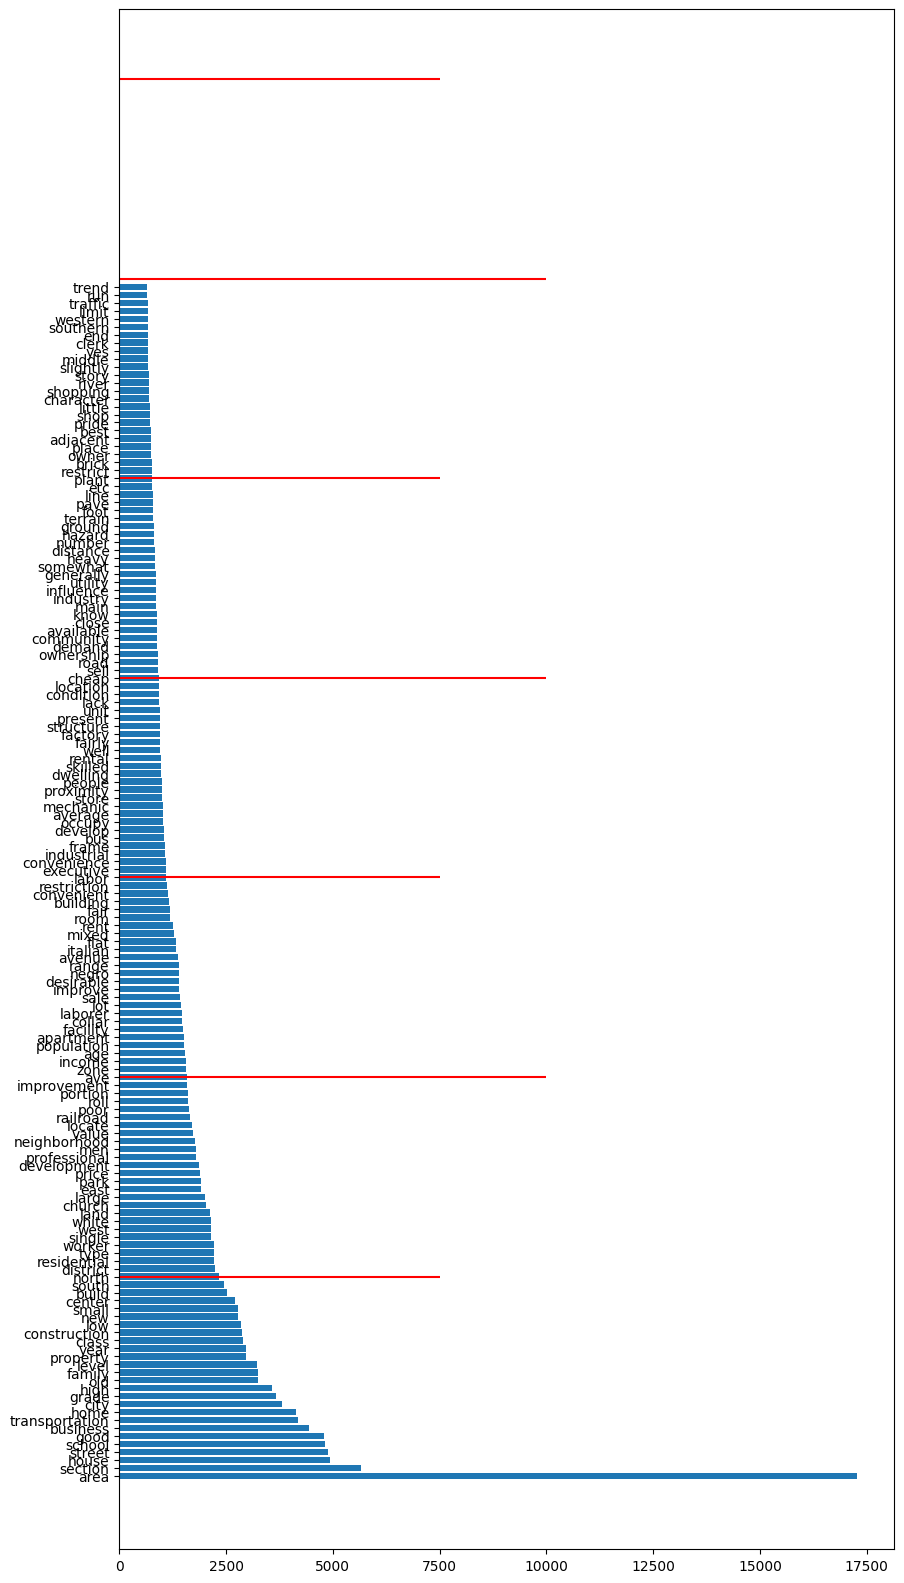

In [8]:
plt.figure(figsize=(10,20))
plt.barh(words, freqs, align='center')
plt.hlines([50, 100, 150], 0, 10000, colors='red')
plt.hlines([25, 75, 125, 175], 0, 7500, colors='red')


We make our cut at the 52nd most common word, since that appears reasonable per some interpretation of the elbow rule.

Let's try cutting uncommon words as well, specifically running with the rule that a word needs to appear at least 30 times to be relevant.

In [9]:
vocab = set()

for word, count in list(words_dist.most_common())[52:]:
    if count > 100:
        vocab.add(word)



In [10]:
ADD_STOP = ['avenue', 'blvd', 'lot', 'street', 'cent', 'road']
tm_data['rreduced_words'] = tm_data['reduced_words'].apply(lambda x: drop_bad(x, add_stop_words=ADD_STOP, vocab_lst=vocab))
tm_data.head()

,area_id,selected_fields,grade,tokenized_text,normalized_tokens,reduced_words,rreduced_words
0,3948,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
1,3929,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
2,3926,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
3,7175,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
4,3938,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."


In [11]:
dictionary = gensim.corpora.Dictionary(tm_data['rreduced_words'])
corpus = [dictionary.doc2bow(text) for text in tm_data['rreduced_words']]
gensim.corpora.MmCorpus.serialize('holc.mm', corpus)
holc_mm = gensim.corpora.MmCorpus('holc.mm')

In [12]:

models, coherences = test_coherences(dictionary, corpus, tm_data['rreduced_words'].tolist(), start=2, limit=8)

In [13]:
coherences

[0.4763320809500089,
 0.5311016599448066,
 0.5428607204147105,
 0.5511514828382129,
 0.5122522189938931,
 0.5283522040514969]

Based on this, index 2, index 5, and index 8 are our most coherent. Let's check those:

In [ ]:
print(make_topic_weight_df(models[2], dictionary, tm_data['area_id'], tm_data['rreduced_words']).head())
print(generate_topic_df(models[2]))

   name  topic_0   topic_1   topic_2   topic_3
0  3948      0.0  0.010103  0.969398  0.013926
1  3929      0.0  0.010103  0.969398  0.013926
2  3926      0.0  0.010103  0.969396  0.013926
3  7175      0.0  0.010103  0.969397  0.013926
4  3938      0.0  0.010103  0.969398  0.013926
       topic_0     topic_1    topic_2    topic_3
0      improve     italian      frame     income
1  convenience       mixed       room  apartment
2       hazard    facility  apartment       sale
3   population        flat      brick      range
4    available  convenient     income  desirable
5       accord     laborer       rent       rent
6  restriction    industry      dwell  structure
7      quality      fairly       unit        bus
8   subversive      polish       sale    traffic
9         lack       labor    present    average


In [ ]:
print(make_topic_weight_df(models[3], dictionary, tm_data['area_id'], tm_data['rreduced_words']).head())
print(generate_topic_df(models[3]))

   name  topic_0  topic_1  topic_2   topic_3   topic_4
0  3948      0.0      0.0      0.0  0.010781  0.969424
1  3929      0.0      0.0      0.0  0.010781  0.969424
2  3926      0.0      0.0      0.0  0.010781  0.969424
3  7175      0.0      0.0      0.0  0.010781  0.969424
4  3938      0.0      0.0      0.0  0.010782  0.969423
       topic_0     topic_1    topic_2    topic_3     topic_4
0      improve     italian      frame  apartment       negro
1  convenience       mixed       room  desirable     laborer
2       hazard    facility     income       sale  population
3    available        flat      brick     income  industrial
4   population  convenient  apartment       rent      double
5       accord      fairly      dwell      range        pave
6  restriction      polish    improve        bus      income
7      quality    industry       rent    average        wage
8   subversive       labor       unit  structure      earner
9          bus    somewhat    present       unit       plant

In [16]:
generate_topic_df(models[3]) 

,topic_0,topic_1,topic_2,topic_3,topic_4
0,improve,italian,frame,apartment,negro
1,convenience,mixed,room,desirable,laborer
2,hazard,facility,income,sale,population
3,available,flat,brick,income,industrial
4,population,convenient,apartment,rent,double
5,accord,fairly,dwell,range,pave
6,restriction,polish,improve,bus,income
7,quality,industry,rent,average,wage
8,subversive,labor,unit,structure,earner
9,bus,somewhat,present,unit,plant


Split by AB / CD

In [11]:
tm_data.head()

,area_id,selected_fields,grade,tokenized_text,normalized_tokens,reduced_words,rreduced_words
0,3948,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
1,3929,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
2,3926,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
3,7175,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
4,3938,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."


In [18]:
tm_data_ab = tm_data[tm_data['grade'].isin(['A', 'B'])]
tm_data_cd = tm_data[tm_data['grade'].isin(['C', 'D'])]


In [23]:
dictionary_ab = gensim.corpora.Dictionary(tm_data_ab['rreduced_words'])
corpus_ab = [dictionary.doc2bow(text) for text in tm_data_ab['rreduced_words']]
gensim.corpora.MmCorpus.serialize('holc_ab.mm', corpus_ab)
holc_mm = gensim.corpora.MmCorpus('holc_ab.mm')
models, coherences = test_coherences(
    dictionary_ab, corpus_ab, 
    tm_data_ab['rreduced_words'].tolist(), 
    start=2, limit=8)

IndexError: index 634 is out of bounds for axis 1 with size 634

In [19]:
dictionary_cd = gensim.corpora.Dictionary(tm_data_cd['rreduced_words'])
corpus_cd = [dictionary.doc2bow(text) for text in tm_data_cd['rreduced_words']]
gensim.corpora.MmCorpus.serialize('holc_cd.mm', corpus_cd)
holc_mm = gensim.corpora.MmCorpus('holc_cd.mm')
models, coherences = test_coherences(
    dictionary_cd, corpus_cd, 
    tm_data_cd['rreduced_words'].tolist(), 
    start=2, limit=8)

In [22]:
coherences

[0.29163696665821504,
 0.28906888990341045,
 0.260168244424925,
 0.28718489949646764,
 0.27150682718281055,
 0.2817638141175699]

In [ ]:
print(make_topic_weight_df(models[3], dictionary, tm_data_cd['area_id'], tm_data_cd['rreduced_words']).head())
print(generate_topic_df(models[3]))

    name   topic_0  topic_1  topic_2  topic_3   topic_4
13  3939  0.975682      0.0      0.0      0.0  0.000000
14  3927  0.978384      0.0      0.0      0.0  0.000000
15  3919  0.260638      0.0      0.0      0.0  0.722237
16  7177  0.977550      0.0      0.0      0.0  0.000000
17  7178  0.981257      0.0      0.0      0.0  0.000000
        topic_0       topic_1     topic_2      topic_3      topic_4
0        bridge         offer        wage  practically    residence
1  considerable      cemetery       owner        multi   industrial
2   principally           low        flat     increase         half
3         board     exception      wooded       wooded  practically
4       vacancy         grand     provide    southeast      utility
5  encroachment         basis        bear    community        offer
6         basis    industrial  industrial        board  principally
7    industrial           way        take          mix         long
8          give          give       offer      brack

## Okay, idea 2: what if we just see what terms are most _predictive_ ?

Let's try a stacking classifier:

Pre-processing: tf-idf?

Base Models:
- Logistic Classifier
- RF
- XGBoost (?)
- SVM

Meta-Model: Logistic Regression (CV)

In [12]:
from sklearn.ensemble import (
    StackingClassifier, 
    RandomForestClassifier,
    AdaBoostClassifier
)
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
tm_data['reduced_docs'] = tm_data.rreduced_words.apply(lambda x: ' '.join(x))

In [13]:
stacker = StackingClassifier(
    estimators = [
        ('lrcv', LogisticRegressionCV()),
        ('svm', SVC(probability=True)),
        ('rfc', RandomForestClassifier()),
        ('abc', AdaBoostClassifier()),
        ('gnb', Pipeline([
            ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
             ('gnb', GaussianNB())
        ]))
    ],
    final_estimator=LogisticRegression()
)


model = Pipeline(
    [
        ('tfidf', TfidfVectorizer(dtype=np.float32)),
        ('stacker', stacker)
    ]
)

In [14]:
model

Pipeline(steps=[('tfidf', TfidfVectorizer(dtype=<class 'numpy.float32'>)),
                ('stacker',
                 StackingClassifier(estimators=[('lrcv',
                                                 LogisticRegressionCV()),
                                                ('svm', SVC(probability=True)),
                                                ('rfc',
                                                 RandomForestClassifier()),
                                                ('abc', AdaBoostClassifier()),
                                                ('gnb',
                                                 Pipeline(steps=[('to_dense',
                                                                  FunctionTransformer(accept_sparse=True,
                                                                                      func=<function <lambda> at 0x0000012885E7A480>)),
                                                                 ('gnb',
                                                                  GaussianNB())]))],
                                    final_estimator=LogisticRegression()))])

In [15]:
tm_data.grade.isna().any()

True

In [19]:
model_tm_data = tm_data[(tm_data.reduced_docs != '') & (~tm_data.grade.isna())]

In [ ]:
stacker = StackingClassifier(
    estimators = [
        ('lrcv', LogisticRegression(max_iter=1000)),
        ('svm', SVC(probability=True)),
        ('rfc', RandomForestClassifier()),
        ('abc', AdaBoostClassifier()),
        ('gnb', Pipeline([
            ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
             ('gnb', GaussianNB())
        ]))
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)


model = Pipeline(
    [
        ('tfidf', TfidfVectorizer(dtype=np.float32)),
        ('stacker', stacker)
    ]
)
X_train, X_test, y_train, y_test = train_test_split(model_tm_data.reduced_docs, model_tm_data.grade)

X_train

model.fit(X_train, y_train)

In [ ]:
stacker.score()

In [53]:
tm_data['reduced_docs'] = tm_data.rreduced_words.apply(lambda x: ' '.join(x))
tfidf_vectorizre = TfidfVectorizer()
tfidf_vects = tfidf_vectorizre.fit_transform(tm_data['reduced_docs'])


In [60]:
pd.DataFrame(tfidf_vects[0].T.todense(), 
             index=tfidf_vectorizre.get_feature_names_out(), 
             columns=['tfidf'])\
                .sort_values(by='tfidf', ascending=False)\
                .head(10)

,tfidf
practically,0.566309
tract,0.478250
presence,0.245644
elevate,0.238487
public,0.202355
principal,0.196985
subdivision,0.195020
modern,0.191914
hill,0.187545
contain,0.172558


## TFIDF Exploration

Out of morbid curiosity:

In [ ]:
def list_of_sents_to_doc(sents: list[str]) -> str:
    '''
    Take a list of strings and return a collated string document.
    '''
    rv = ''
    for sent in sents:
        rv = rv + sent + ". "

    return rv

meta_documents = {'A':'', 'B':'', 'C':'', 'D':''}

for grade in ['A', 'B', 'C', 'D']:
    rel_docs = tm_data[tm_data['grade']==grade]
    sents = list_of_sents_to_doc(rel_docs.reduced_docs)
    meta_documents[grade] = sents

grade_df = pd.DataFrame(meta_documents, index=['text'])\
    .T\
    .reset_index()\
    .rename(columns={'index':'grade'})


grade_df

,grade,text
0,A,contain practically modern elevate principal s...
1,B,contain poorer repair remain eastern western g...
2,C,mortgage available restrict basis percentage c...
3,D,lender lend restrict basis northern washington...


In [73]:
grade_vectorizer = TfidfVectorizer()
grade_vectors = grade_vectorizer.fit_transform(grade_df.text)

In [86]:
meta_docs = pd.DataFrame(grade_vectors.T.todense(), 
             index=grade_vectorizer.get_feature_names_out(), 
             columns=['a_tfidf', 'b_tfidf', 'c_tfidf', 'd_tfidf'])

In [87]:
meta_docs.sort_values(by='a_tfidf', ascending=False).head(10)

,a_tfidf,b_tfidf,c_tfidf,d_tfidf
executive,0.309463,0.154630,0.029851,0.001584
restrict,0.209005,0.098665,0.023840,0.009824
desirable,0.173946,0.210917,0.086238,0.023767
range,0.159114,0.133603,0.106139,0.071617
restriction,0.155743,0.106106,0.082713,0.047534
highly,0.134842,0.026203,0.009950,0.009824
develop,0.131471,0.111282,0.083543,0.041513
income,0.129448,0.124868,0.137441,0.129608
improve,0.127426,0.132309,0.111321,0.082392
sale,0.124055,0.126486,0.101371,0.112179


In [88]:
meta_docs.sort_values(by='d_tfidf', ascending=False).head(20)

,a_tfidf,b_tfidf,c_tfidf,d_tfidf
laborer,0.000674,0.010675,0.106139,0.293758
negro,0.012810,0.026203,0.062605,0.270308
italian,0.003371,0.026203,0.132051,0.193303
population,0.097761,0.098018,0.108626,0.174924
yes,0.000000,0.006727,0.039048,0.168220
industrial,0.015507,0.035261,0.089969,0.162565
labor,0.002023,0.029114,0.105931,0.157812
income,0.129448,0.124868,0.137441,0.129608
industry,0.006068,0.020057,0.080848,0.129291
mixed,0.006068,0.054023,0.132466,0.127707


In [90]:
# lets just get all top 10s
top_tfidf = {}
nwords = 20
for grade in ['a', 'b', 'c', 'd']:
    words = meta_docs.sort_values(by=f'{grade}_tfidf', ascending=False).head(nwords).index
    top_tfidf[grade] = words.tolist()

pd.DataFrame(top_tfidf, index=list(range(nwords)))

,a,b,c,d
0,executive,desirable,apartment,laborer
1,restrict,collar,age,negro
2,desirable,executive,collar,italian
3,range,range,income,population
4,restriction,apartment,flat,yes
5,highly,improve,mixed,industrial
6,develop,age,italian,labor
7,income,facility,facility,income
8,improve,sale,fair,industry
9,sale,income,mechanic,mixed
